In [5]:
from time import perf_counter
import os
from joblib import Parallel, delayed
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

from src import utils
from src import models

SEED = 10
N_CPUS = os.cpu_count()

np.random.seed(SEED)

In [6]:
def run_experiment(g, Exps, graph_p, signal_p, def_args, verb):
    Adj_list = utils.create_dinamic_graph(**graph_p)
    X_list, X0 = utils.create_dinamic_gmrf_signals(Adj_list, **signal_p)

    n_iters = np.array( [X_i.shape[1] for X_i in X_list] ).sum()
    n_iters *= def_args['iters_sample'] if 'iters_sample' in def_args.keys() else 1
    n_iters += len(X_list)
    
    err_graphs = np.zeros((len(Adj_list), len(Exps)))
    err_seq = np.zeros((n_iters, len(Exps)))
    err_first = np.zeros_like(err_graphs)
    runtime = np.zeros(len(Exps))
    for i, exp in enumerate(Exps):
        args_aux = {**def_args, **exp['args']} if 'args' in exp.keys() else {**def_args}
        model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
        t_init = perf_counter()
        model.fit(X_list, **args_aux)
        t_end = perf_counter()

        err_graphs[:,i] = model.test_err(Adj_list)
        err_seq[:,i] = model.test_sequence_err(Adj_list)
        err_first[:,i] = model.test_err_graph_i(Adj_list, 0)
        runtime[i] = t_end - t_init

        if verb and g % N_CPUS == 0:
            print(f'- {g+1}. {exp["leg"]}: Err 1st graph: {err_graphs[0,i]:.3f}   -   Err last graph: {err_graphs[-1,i]:.3f}   ' +\
                  f'-   time: {runtime[i]:.3f} secs')

            print('\t args_aux')
            

    return err_graphs, err_seq, err_first, runtime

def plot_data(axes, data, exps, xvals, xlabel, ylabel, skip_idx=[], agg='mean', deviation=None,
              alpha=.25, plot_func='plot'):
    if agg == 'median':
        agg_data = np.median(data, axis=0)
    else:
        agg_data = np.mean(data, axis=0)

    std = np.std(data, axis=0)
    prctile25 = np.percentile(data, 25, axis=0)
    prctile75 = np.percentile(data, 75, axis=0)

    for i, exp in enumerate(exps):
        if i in skip_idx:
            continue
        getattr(axes, plot_func)(xvals, agg_data[:,i], exp['fmt'], label=exp['leg'])

        if deviation == 'prctile':
            up_ci = prctile25[:,i]
            low_ci = prctile75[:,i]
            axes.fill_between(xvals, low_ci, up_ci, alpha=alpha)
        elif deviation == 'std':
            up_ci = agg_data[:,i] + std[:,i]
            low_ci = np.maximum(agg_data[:,i] - std[:,i], 0)
            axes.fill_between(xvals, low_ci, up_ci, alpha=alpha)

    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.grid(True)
    axes.legend()


def plot_all_results(exps, err_graphs, err_seq, err_first, graph_p):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Compute growing number of nodes
    graph_dims = np.ones(len(graph_p['new_nodes']) + 1) * graph_p['n_nodes']
    for i, new_nodes in enumerate(graph_p['new_nodes']):
        graph_dims[i+1] = graph_dims[i] + new_nodes

    plot_data(axes[0], err_graphs, exps, graph_dims, 'Number of nodes', 'Error growing graph', deviation='prctile')
    plot_data(axes[1], err_first, exps, graph_dims, 'Number of nodes', 'Error 1st block', deviation='prctile')
    plot_data(axes[2], err_seq, exps, np.arange(err_seq[0].shape[0]), 'Number of nodes', 'Error seq', deviation='prctile')
    plt.tight_layout()


# Low variance regime

In [7]:
n_graphs = 50
N = 50
verb = True
graph_p = {
    'n_nodes': N,
    'edges': N*4,
    'graph_type': 'er',
    'edge_type': 'positive',
    'new_nodes': [10]*2,
    'new_edges': 4,
    'load_adjs_fact': .01, #.01,
    'conn_nodes': True,
}

## Signal parameters
signal_p = {
    'samples_t': 1000,
    'noise_power': .05,
}

## Offline model

CPUs employed: 128
- 1. Incr: Err 1st graph: 0.073   -   Err last graph: 0.084   -   time: 38.311 secs
	 args_aux
----- Solved in 0.680 minutes -----


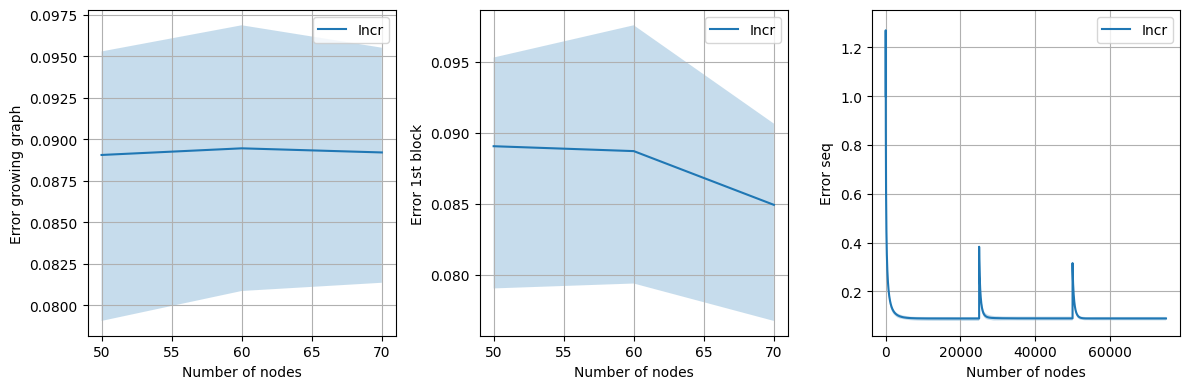

In [8]:
# Default args
default_args = {
    'iters_sample': 10,
    'lamb': 1e-2,
    'stepsize': 5e-3,
    'gamma': .95, 
    'epsilon': .1,
    'alpha': 0,
}

Exps = [
    {'model': models.Offline_dyn_nti, 'args': {'lamb': 5e-4,}, 'leg': 'Incr', 'fmt': '-'},
    {'model': models.Offline_dyn_nti, 'args': {'lamb': 1e-3,}, 'leg': 'Incr', 'fmt': '-'},
    {'model': models.Offline_dyn_nti, 'args': {'lamb': 5e-3,}, 'leg': 'Incr', 'fmt': '-'},
    {'model': models.Offline_dyn_nti, 'args': {'lamb': 1e-2,}, 'leg': 'Incr', 'fmt': '-'},
    {'model': models.Offline_dyn_nti, 'args': {'lamb': 5e-2,}, 'leg': 'Incr', 'fmt': '-'},
    {'model': models.Offline_dyn_nti, 'args': {'lamb': 1e-1,}, 'leg': 'Incr', 'fmt': '-'},
    {'model': models.Offline_dyn_nti, 'args': {'lamb': 5e-1,}, 'leg': 'Incr', 'fmt': '-'},
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_graphs, err_seq, err_first, runtime = zip(*results)

plot_all_results(Exps, err_graphs, err_seq, err_first, graph_p)

# High Variance Regime

In [4]:
n_graphs = 50
N = 50
graph_p = {
    'n_nodes': N,
    'edges': N*4,
    'graph_type': 'er',
    'edge_type': 'positive',
    'new_nodes': [2]*75,
    'new_edges': 4,
    'load_adjs_fact': .01, #.01,
    'conn_nodes': True,
}

## Signal parameters
signal_p = {
    'samples_t': [1000] + [50]*75,
    'noise_power': .05,
}